# Model Examples

## General setup

We first setup the notebook for plotting inline, in svg format, and indented pretty print.

In [1]:
import matplotlib.pyplot as P
import numpy as N
from IPython.display import set_matplotlib_formats, Code
import pprint
pp = pprint.PrettyPrinter(indent=4, compact = True)

%matplotlib inline
set_matplotlib_formats('svg')


We then tune the figure parameters

In [2]:
P.rcParams["figure.figsize"] = (12, 9)
P.rcParams['image.cmap'] = "seismic" # palette for good contrast
P.rc("font", size=16)

We also tune the display of pandas dataframes:

In [3]:
import pandas as pd
pd.options.display.max_columns = 8


At last, the ResultReader from metadynamic package is loaded

In [4]:
from metadynamic import ResultReader, __version__
print(f"Data read with metadynamic version: {__version__}")


Data read with metadynamic version: 1.0.3


## Simple system

This is a simple run, for a minimalist system with a minimal set of possible reactions:

- ABC → A + BC
- ABC → AB + C
- AB → A + B
- BC → B + C

These reactions are implicitely built from an `hydrolysis` rule, with the introduction of the `ABC` compound at the initial state.

### Code

A `json` file describes the run parameters:

In [5]:
Code(filename="simple.json")

{
    "name" : "Simple",
    "savedir" : "",
    "logdir" : "runlog",
    "init" :
    {
	"abc": 1000
    },
    "conc" : 1.0,
    "tend" : 10.0,
    "tstep" : 0.1,
    "save" : ["a", "b", "c", "abc", "ab", "bc"],
    "stat" : "simple-stat.json",
    "rulemodel" : "simple.py",
    "reactions" : "H",
   "parameters" :{
	"khyd_head" : 1.0,
	"khyd_queue" : 0.5
    }
}

Collected statistics are define in `simple-stat.json`:

In [6]:
Code(filename="simple-stat.json")

{
    "nbcomp":
    {
	"method" : "+"
    },
    "poolsize":
    {
	"method" : "+",
	"full" : true
    },
    "nbreac":
    {
	"method" : "+",
	"collection" : "reactions"
    },
    "poolreac":
    {
	"method" : "+",
	"collection" : "reactions",
	"full" : true
    },
    "mix_entro":
    {
	"prop" : "entropy",
	"method" : "m"
    }
}

The rules describing the hydrolysis reaction rule are described as a python module:

- a Categorizer function classify compounds with alphabetic names as `polym`;
- a Propertizer function computes the property `length` of compounds;
- a ProdBuilder function defines how a compound can be `cut`, e.g. `cut(["abcdef"], 3)` returns `("abc", "def")`;
- a Constbuilder function set kinetic constants to `khyd_head` for reaction with `variant=1` (i.e. if the hydrolysis only cuts the first monomer), and to `khyd_queue` in other cases;
- a VariantBuilder function gives all the possible reaction variants that can be obtained for the hydrolysis of a given compound (e.g. for the hydrolysis of "`ABCD"`, the possible variants are `[1,2,3]`;
- the set of rules is finally obtained by assembling these elements in a `default_ruleset` dictionary.


In [7]:
Code(filename="simple.py")

from typing import Dict, Any

from metadynamic.ruleset import (
    Categorizer,
    Propertizer,
    ProdBuilder,
    ConstBuilder,
    VariantBuilder,
    kalternate,
    rangevariant,
)


# Categorizer

# A polymer is a chain of characters, e.g. abc
polym: Categorizer = lambda name: name.isalpha()

# Propertizer
length: Propertizer = lambda name: len(name)

# ProdBuilder

# e.g. abcdef -[3]-> abc + def
cut: ProdBuilder = lambda names, variant: (names[0][:variant], names[0][variant:])

# ConstBuilder

khyd: ConstBuilder = kalternate(
    condition=lambda names, variant: variant == 1,
    name_t="khyd_head",
    name_f="khyd_queue",
)

# (length-1) possible reactions from a given reaction
# (e.g. abc -[1]-> a+bc and abc -[2]->  ab+c)
intervariant: VariantBuilder = rangevariant(reacnum=0, first_offset=1)

# Default Ruleset

default_ruleset: Dict[str, Any] = {
    "categories": ["polym"],
    "properties": ["length"],
    "rules": {
        "H": {
            "reactants": ["polym"],
            "builder_func": "cut",
            "builder_const": "khyd",
            "builder_variant": "intervariant",
            "descr": "Hydrolysis",
        },
    },
}

### Results

A run was launched by `mpirun -np 40 metarun -c "Simple polymer hydrolysis" simple.json`.
All results were recorded in a single `hdf5` file:

In [8]:
res = ResultReader("simple.hdf5")
end = res.params.attrs["tend"]
print(res.printinfo)

---------------
Simple polymer hydrolysis
---------------
metadynamic version 1.0.3, ran on 40 threads on Lady3Jane
from [17.06.2020-18:23:02] to [17.06.2020-18:23:08]
results saved in 'simple.hdf5'
---------------
#0: ending n°11 at runtime t=5.0613179206848145s; No more reactions can be processed -> after processing ab->a+b
#1: ending n°11 at runtime t=5.257615089416504s; No more reactions can be processed -> after processing ab->a+b
#2: ending n°11 at runtime t=4.8293256759643555s; No more reactions can be processed -> after processing ab->a+b
#3: ending n°11 at runtime t=5.259350776672363s; No more reactions can be processed -> after processing ab->a+b
#4: ending n°11 at runtime t=6.472845554351807s; No more reactions can be processed -> after processing bc->b+c
#5: ending n°11 at runtime t=5.465683460235596s; No more reactions can be processed -> after processing ab->a+b
#6: ending n°11 at runtime t=4.195853233337402s; No more reactions can be processed -> after processing ab->a+b

Full data table (averaged values over each run):

In [9]:
res.table()

,0,1,2,3,...,86,87,88,89
thread,19.500000,19.500000,19.500000,19.500000,...,17.250000,18.666666,11.000000,18.000000
ptime,0.020939,0.080729,0.139240,0.198096,...,5.973405,6.175939,6.247884,6.296824
memuse,156.804977,156.828812,156.882614,156.887207,...,158.212891,158.531250,158.804688,157.878906
step,0.000000,1.000000,2.000000,3.000000,...,86.000000,87.000000,88.000000,89.000000
dstep,0.000000,143.949997,285.075012,415.325012,...,1999.000000,1999.000000,1999.000000,1999.000000
time,0.000000,0.100570,0.200734,0.300670,...,8.778773,8.828137,8.870058,8.905825
a,0.000000,0.030608,0.059858,0.085500,...,0.333167,0.333222,0.333167,0.333000
b,0.000000,0.002175,0.008650,0.017967,...,0.333000,0.333000,0.333000,0.333000
c,0.000000,0.017375,0.035167,0.052942,...,0.333167,0.333111,0.333167,0.333333
abc,0.333333,0.287525,0.246958,0.212858,...,0.000000,0.000000,0.000000,0.000000


The concentration of each compound can be plotted (thick line for the average over all runs, thin line for each run)

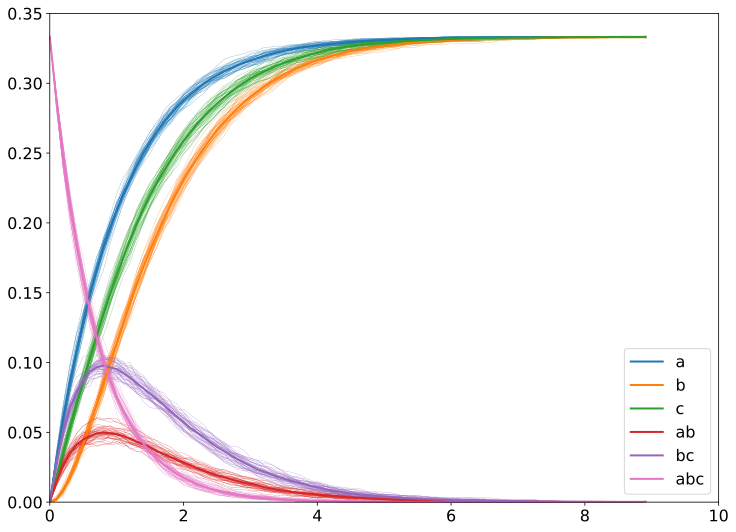

In [10]:
names = ["a", "b", "c", "ab", "bc", "abc"]
colors = ["blue", "orange", "green", "red", "purple", "pink"]

for name, color in zip(names, colors):
    P.plot(*res.x_y_proc(name), linewidth=0.2, color=f"tab:{color}")

for name, color in zip(names, colors):
    P.plot(*res.x_y(name), linewidth=2, color=f"tab:{color}", label=name)
    


P.legend()
P.xlim(0,end)
P.ylim(0);

A more complexe simulation can simply be performed by changing the initial conditions: here, the reaction starts from a larger polymer (`abcdefgh` instead of `abc`), with a larger number of individual compounds (`10000` instead of `1000`)

In [11]:
Code(filename="simple-large.json")

{
    "name" : "Simple-Large",
    "savedir" : "",
    "logdir" : "runlog",
    "init" :
    {
	"abcdefgh": 10000
    },
    "conc" : 1.0,
    "tend" : 10.0,
    "tstep" : 0.1,
    "save" : ["a", "b", "c", "d", "e", "f", "g", "h", "abcdefgh", "abc", "ab", "de", "gh"],
    "stat" : "simple-stat.json",
    "rulemodel" : "simple.py",
    "reactions" : "H",
   "parameters" :{
	"khyd_head" : 1.0,
	"khyd_queue" : 0.5
    }
}

In [12]:
res = ResultReader("simple-large.hdf5")
end = res.params.attrs["tend"]
print(res.printinfo)

---------------
Simple polymer hydrolysis, large system
---------------
metadynamic version 1.0.3, ran on 40 threads on Lady3Jane
from [17.06.2020-17:44:37] to [17.06.2020-17:44:46]
results saved in 'simple-large.hdf5'
---------------
#0: ending n°10 at runtime t=8.21920108795166s; Time is up -> t=10.187811784278523
#1: ending n°10 at runtime t=8.44766902923584s; Time is up -> t=10.003532644099032
#2: ending n°10 at runtime t=8.223361015319824s; Time is up -> t=10.059031603960552
#3: ending n°10 at runtime t=7.669910430908203s; Time is up -> t=10.038173242406277
#4: ending n°10 at runtime t=7.678255081176758s; Time is up -> t=10.225649865415996
#5: ending n°10 at runtime t=8.30026912689209s; Time is up -> t=10.027439663486193
#6: ending n°10 at runtime t=7.730308532714844s; Time is up -> t=10.000161064968815
#7: ending n°10 at runtime t=8.30341625213623s; Time is up -> t=10.379548101500573
#8: ending n°10 at runtime t=7.929832935333252s; Time is up -> t=10.165143834867216
#9: ending n°

In [13]:
res.table()

,0,1,2,3,...,97,98,99,100
thread,19.500000,19.500000,19.500000,19.500000,...,19.684210,19.684210,20.161291,23.157894
ptime,0.020405,0.251657,0.465878,0.679167,...,7.769607,7.879498,8.009893,8.160428
memuse,156.434967,156.499420,156.658600,156.664062,...,157.055710,157.128906,157.271164,157.434006
step,0.000000,1.000000,2.000000,3.000000,...,97.000000,98.000000,99.000000,100.000000
dstep,0.000000,3957.949951,7840.125000,11606.275391,...,69991.078125,69991.898438,69992.609375,69993.687500
time,0.000000,0.100022,0.200033,0.300034,...,9.810226,9.903000,10.021119,10.208082
a,0.000000,0.011965,0.022785,0.032502,...,0.124993,0.124994,0.124994,0.124995
b,0.000000,0.000856,0.003181,0.006639,...,0.124982,0.124985,0.124987,0.124989
c,0.000000,0.000469,0.001763,0.003892,...,0.124970,0.124974,0.124976,0.124981
d,0.000000,0.000457,0.001754,0.003803,...,0.124962,0.124963,0.124965,0.124969


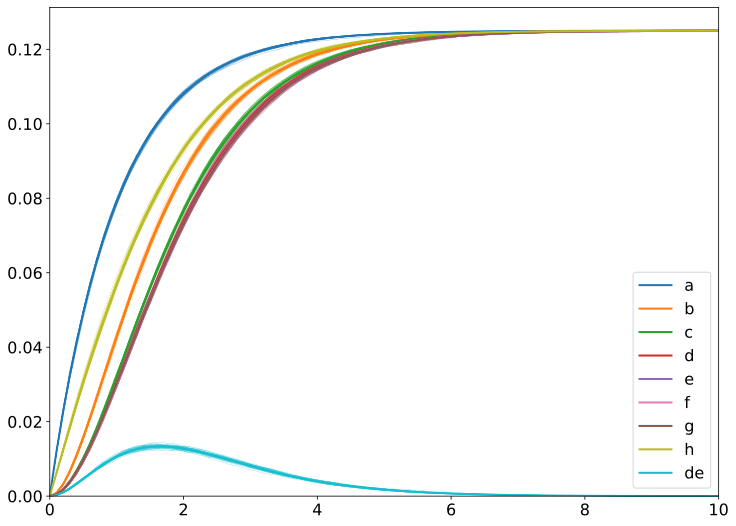

In [14]:
names = ["a", "b", "c", "d", "e", "f", "g", "h", "de"]
colors = ["blue", "orange", "green", "red", "purple", "pink", "brown", "olive", "cyan"]

for name, color in zip(names, colors):
    P.plot(*res.x_y_proc(name), linewidth=0.2, color=f"tab:{color}")

for name, color in zip(names, colors):
    P.plot(*res.x_y(name), linewidth=2, color=f"tab:{color}", label=name)
    


P.legend()
P.xlim(0,end)
P.ylim(0);

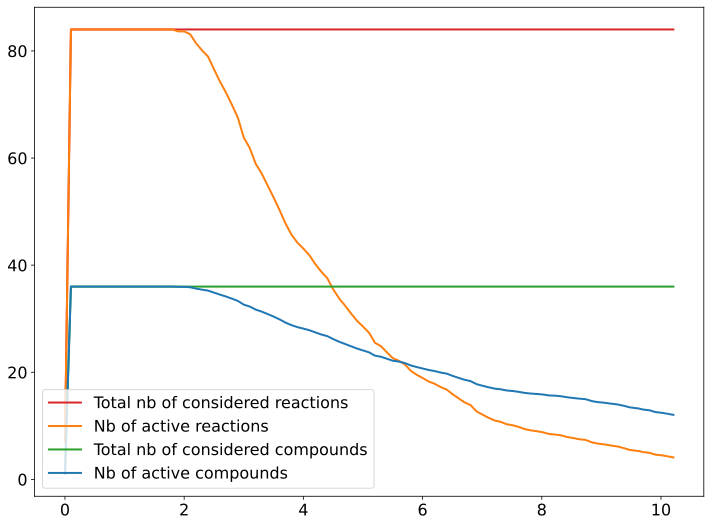

In [15]:
P.plot(*res.x_y("poolreac"), linewidth=2, color="tab:red", label="Total nb of considered reactions")
P.plot(*res.x_y("nbreac"), linewidth=2, color="tab:orange", label="Nb of active reactions")
P.plot(*res.x_y("poolsize"), linewidth=2, color="tab:green", label="Total nb of considered compounds")
P.plot(*res.x_y("nbcomp"), linewidth=2, color="tab:blue", label="Nb of active compounds")

P.legend();


## APED system

This is a complete example, 

### Code

Simulation ruleset code.

- Categorizer functions are defined for being able to categorize a compound from its name (for example `polymer("AbCD")` returns `True`, thus a compound with name `"AbCD"` will be categorized as a `polymer`)
- Propertizer functions are defined for computing a compound property from its name (for example `length("AbCD*")` returns `4`, thus the compound of name `"AbCD*"` posesses a `length` of value `4`)
- ProdBuilder functions are defined for computing a list of names of product compounds, from a list of names of reactant compounds and a reaction variant number (for example `cut(names=["ABCD"], variant=1)` will return `["A", "BCD"]`; it will be used for processing the hydrolysis reaction `ABCD → A + BCD`
- ConstBuilder functions are defined for computing a kinetic constant from ...
...
- The Ruleset is defined by assembling all theses previously defined elements, for creating all the rules necessary for defining all possible chemical reactions.


In [16]:
Code(filename="aped.py")

"""APED model definition module

This system is defined by:
 - Activation reaction; e.g.  A -> A*
 - Activated polymerisation reaction; e.g.  A* + BcD -> ABcD
 - Epimerization reaction; e.g.  ABcD -> aBcD
 - Depolymerization reaction; e.g.  aBcD -> aBc + D
"""

from typing import Dict, Any

from metadynamic.ruleset import (
    Categorizer,
    Propertizer,
    ProdBuilder,
    ConstBuilder,
    VariantBuilder,
    Compset,
    kalternate,
    kdualchoice,
    novariant_gen,
    singlevariant,
    rangevariant,
)

# Definition of Categorizer and Propertizer functions

polym: Categorizer = lambda name: name.isalpha()
"""Definition of a polymer

Return True if the name is an alphabetic string:
>>> polym("AaDcs")
True
>>> polym("A2")
False
"""

mono: Categorizer = lambda name: polym(name) and len(name) == 1
"""Definition of a monomer

Return True if the name is polymer of length one:
>>> mono("Abc")
False
>>> mono("b")
True
"""

actpol: Categorizer = lambda name: name[-1] == "*" and name[:-1].isalpha()
"""Definition of an activated polymer

Return True if the name is an alphabetic string + a '*' char at its end:
>>> actpol("AbcD")
False
>>> actpol("Abcd*")
True
"""


actmono: Categorizer = lambda name: actpol(name) and len(name) == 2
"""Definition of an activated monomer

Return True is the name is an activated polymer of length 2:
>>> actmono("Abcd*")
False
>>> actmono("A*")
True
"""

longpol: Categorizer = lambda name: polym(name) and len(name) > 1
"""Definition of a long polymer

Return True if the name is a polymer of length 2 or more:
>>> longpol("A")
False
>>> longpol("Abcd")
True
"""


length: Propertizer = lambda name: (
    1
    if mono(name)
    else len(name)
    if polym(name)
    else len(name) - 1
    if actpol(name)
    else 0
)
"""Definition of length property

Return the length of a monomer, polymer or activated polymer:
>>> length('A')
1
>>> length('AbCD')
4
>>> length('Ab*')
3
>>> length('A2')
0
"""


def asym(name: str) -> int:  # Propertizer
    """Definition of asymmetry property

    Each upper char in the name is counted as +1, each lower char as -1:
    >>> asym('AAAa')
    2
    >>> asym('AAAA')
    4
    >>>> asym('aaaa')
    -4
    >>>> asym('aAAa')
    0
    """
    res = 0
    for char in name:
        if char.isupper():
            res += 1
        elif char.islower():
            res -= 1
    return res


right: Categorizer = lambda name: asym(name) > 0
"""Definition of right category

Return True if the name has a positive asymmetry property.
"""

left: Categorizer = lambda name: asym(name) < 0
"""Definition of left category

Return True if the name has a negative asymmetry property.
"""


# Definition of ProdBuilder functions

cut: ProdBuilder = lambda names, variant: (names[0][:variant], names[0][variant:])
act_polym: ProdBuilder = lambda names, variant: (names[0][:-1] + names[1],)
activ: ProdBuilder = lambda names, variant: (names[0] + "*",)
epimer: ProdBuilder = lambda names, variant: (
    names[0][:variant] + names[0][variant].swapcase() + names[0][variant + 1 :],
)


# ConstBuilder


def samecase(one: str, two: str) -> bool:
    return (one.islower() and two.islower()) or (one.isupper() and two.isupper())


def samebefore(names: Compset, variant: int) -> bool:
    name = names[0]
    return variant < (length(name) - 1) and samecase(name[variant], name[variant + 1])


def sameafter(names: Compset, variant: int) -> bool:
    name = names[0]
    return (variant > 0) and samecase(name[variant], name[variant - 1])


kpola: ConstBuilder = kalternate(
    condition=lambda names, variant: samecase(names[0][-2], names[1][0]),
    name_t="kpola_same",
    name_f="kpola_diff",
)

kact: ConstBuilder = kalternate(
    condition=lambda names, variant: length(names[0]) == 1,
    name_t="kact_mono",
    name_f="kact_pol",
)

khyd: ConstBuilder = kalternate(
    condition=lambda names, variant: samecase(names[0][variant - 1], names[0][variant]),
    name_t="khyd_same",
    name_f="khyd_diff",
)

kepi: Cons

Simulation parameters:

In [17]:
Code(filename="aped.json")

{
    "name" : "APED",
    "savedir" : "",
    "logdir" : "testlog",
    "init" :
    {
	"a": 10000,
	"A": 10000
    },
    "conc" : 3.0,
    "tend" : 1000.0,
    "tstep" : 5.0,
    "sstep" : 50.0,
    "save" : ["a", "aa", "aaa", "aaaa", "A", "Aa", "aA", "AA", "a*", "A*"],
    "stat" : "aped-stat.json",
    "maps" : "aped-maps.json",
    "rtlim" : 6000.0,
    "rulemodel" : "aped.py",
    "reactions" : ["A", "H", "E", "a"],
    "parameters" :{
	"kpola_same": 1.0,
	"kpola_diff": 0.1,
	"khyd_same": 1.0,
	"kepi_diff": 1.0,
	"kact_mono": 1.0
    },
    "dropmode" : "drop",
    "maxsteps" : 100000,
    "maxlog" : 1000
}

In [18]:
Code(filename="aped-stat.json")

{
    "nbcomp":
    {
	"method" : "+"
    },
    "poolsize":
    {
	"method" : "+",
	"full" : true
    },
    "nbreac":
    {
	"method" : "+",
	"collection" : "reactions"
    },
    "poolreac":
    {
	"method" : "+",
	"collection" : "reactions",
	"full" : true
    },
    "len_mean":
    {
	"prop" : "length"
    },
    "len_min":
    {
	"prop" : "length",
	"method" : "min"
    },
    "len_max":
    {
	"prop" : "length",
	"method" : "max"
    },
    "len_max_pool":
    {
	"prop" : "length",
	"method" : "max",
	"full" : true
    },
    "wlen_mean":
    {
	"prop" : "length",
	"weight" : "pop",
	"method" : "m"
    },
    "slen_mean":
    {
	"prop" : "length",
	"weight" : "single",
	"method" : "m"
    },
    "slen_sum":
    {
	"prop" : "length",
	"weight" : "single",
	"method" : "+"
    },
    "tot_m":
    {
	"prop" : "length",
	"weight" : "pop",
	"method" : "+"
    },
    "tot_c":
    {
	"prop" : "pop",
	"weight" : "count",
	"method" : "+"
    },
    "asym":
    {
	"prop" : "asym",
	"weight" : "pop",
	"method" : "+"
    },
    "mix_entro":
    {
	"prop" : "entropy",
	"method" : "m"
    },
    "reac_entro":
    {
	"prop" : "entropy",
	"method" : "m",
	"collection" : "reactions"
    },
    "nbact":
    {
	"prop" : "actpol",
	"weight": "pop",
	"method" : "+"
    }
}

In [19]:
Code(filename="aped-maps.json")

{
    "lendist":
    {
	"prop" : "pop",
	"sort" : "length"
    },
    "pooldist":
    {
	"prop" : "pop",
	"sort" : "length",
	"full" : true
    },
    "wlendist":
    {
	"prop" : "pop",
	"weight" : "length",
	"sort" : "length"
    },
    "slendist":
    {
	"prop" : "pop",
	"weight" : "single",
	"sort" : "length"
    },
    "asymdist":
    {
	"prop" : "asym",
	"weight" : "pop",
	"method" : "+",
	"sort" : "length"
    },
    "s_asymdist":
    {
	"prop" : "asym",
	"weight" : "single",
	"method" : "+",
	"sort" : "length"
    }
}

### Load result

Results from a simulation are loaded

In [20]:
res = ResultReader("aped.hdf5")

Informations from the run can be printed

In [21]:
nbthread = res.size
end = res.params.attrs["tend"]
print(res.printinfo)

---------------
APED model simulation
---------------
metadynamic version 1.0.3, ran on 40 threads on Lady3Jane
from [17.06.2020-18:24:36] to [17.06.2020-18:39:39]
results saved in 'aped.hdf5'
---------------
#0: ending n°10 at runtime t=825.5508422851562s; Time is up -> t=1000.0000515196389
#1: ending n°10 at runtime t=830.7669067382812s; Time is up -> t=1000.0001392360559
#2: ending n°10 at runtime t=820.9674682617188s; Time is up -> t=1000.000088977672
#3: ending n°10 at runtime t=801.3841552734375s; Time is up -> t=1000.0000267902902
#4: ending n°10 at runtime t=815.4992065429688s; Time is up -> t=1000.0000324070086
#5: ending n°10 at runtime t=799.7250366210938s; Time is up -> t=1000.0000092607021
#6: ending n°10 at runtime t=862.9981689453125s; Time is up -> t=1000.0003375010881
#7: ending n°10 at runtime t=788.2300415039062s; Time is up -> t=1000.0000158103078
#8: ending n°10 at runtime t=838.3408813476562s; Time is up -> t=1000.0000767201893
#9: ending n°10 at runtime t=803.222

### Data tables

A data summary can be obtained:

In [22]:
res.table()

,0,1,2,3,...,197,198,199,200
thread,19.500000,19.500000,19.500000,19.500000,...,1.950000e+01,1.950000e+01,1.950000e+01,1.950000e+01
ptime,0.041191,6.294599,13.148355,20.000538,...,8.106398e+02,8.139094e+02,8.170480e+02,8.205410e+02
memuse,157.377151,157.634674,157.681061,157.724808,...,1.583239e+02,1.584012e+02,1.584183e+02,1.584646e+02
step,0.000000,1.000000,2.000000,3.000000,...,1.970000e+02,1.980000e+02,1.990000e+02,2.000000e+02
dstep,0.000000,74430.101562,143686.546875,212911.453125,...,1.672340e+07,1.681108e+07,1.689872e+07,1.698642e+07
time,0.000000,5.000078,10.000082,15.000078,...,9.850000e+02,9.900000e+02,9.950000e+02,1.000000e+03
a,1.500000,0.331976,0.338546,0.333101,...,3.294338e-01,3.288900e-01,3.306488e-01,3.296250e-01
aa,0.000000,0.192176,0.192364,0.194156,...,1.960987e-01,1.953187e-01,1.960425e-01,1.962375e-01
aaa,0.000000,0.045795,0.044554,0.044925,...,5.100375e-02,5.089125e-02,5.088000e-02,5.068124e-02
aaaa,0.000000,0.007076,0.007215,0.006979,...,8.463750e-03,8.951250e-03,8.493750e-03,8.606249e-03


### Chemical reaction networks

We can check the CRN before bifurcation...

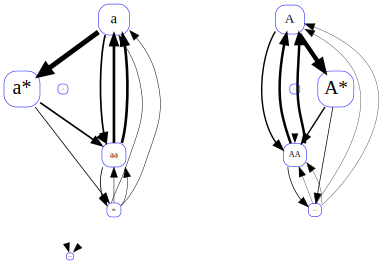

In [23]:
res.getsnap(3,0)

... and after bifurcation

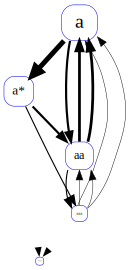

In [24]:
res.getsnap(3,-1)

### Plotting

We can plot time evolution of compounds (per thread and average behavior)

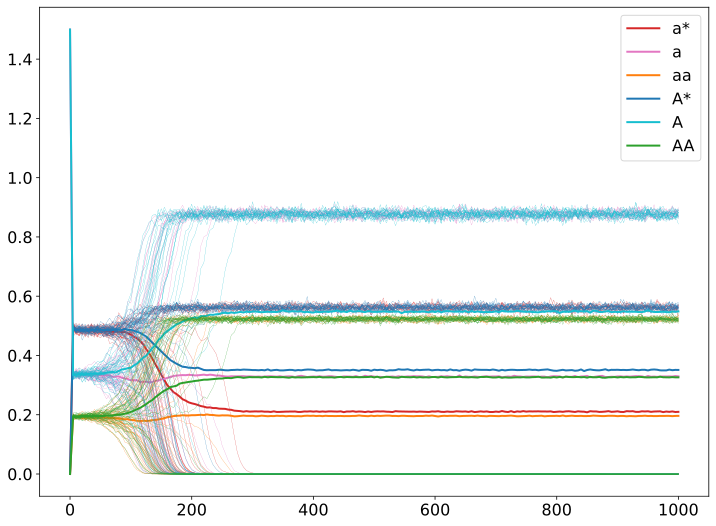

In [25]:
complist = ["a*", "a", "aa", "A*", "A", "AA"]
colorlist = ["tab:red", "tab:pink", "tab:orange", "tab:blue", "tab:cyan", "tab:green"]

for name, color in zip(complist, colorlist):
    P.plot(*res.x_y_proc(name), linewidth=0.2, color=color)
    P.plot(*res.x_y(name, method="p1"), linewidth=0.2, color=color)    
    P.plot(*res.x_y(name), linewidth=2, color=color, label=name)
    

P.legend()



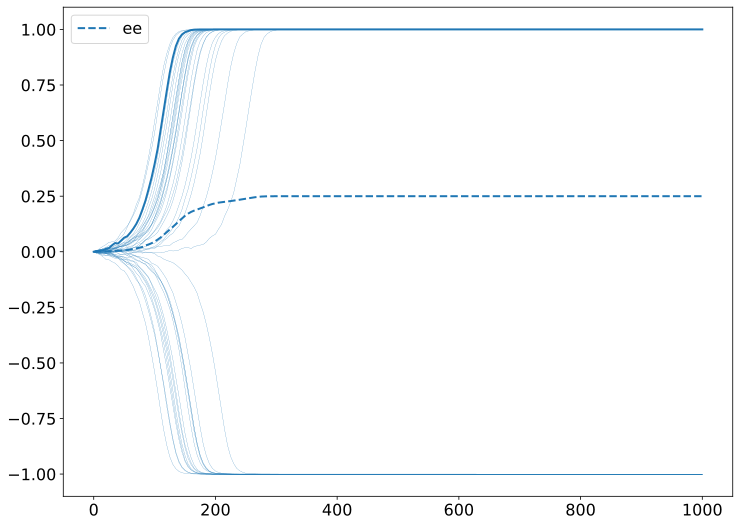

In [26]:
for i in range(nbthread):
    P.plot(res.get("time", method=f"p{i}"), res.get("asym", method=f"p{i}")/res.get("tot_m", method=f"p{i}"), linewidth=0.2, color="tab:blue", label="")
P.plot(res.get("time", method=f"p{i}"), res.get("asym", method=f"p{i}")/res.get("tot_m", method=f"p{i}"), linewidth=2, color="tab:blue", label="")
P.plot(res.get("time", method="m"), res.get("asym", method="m")/res.get("tot_m", method="m"), "--", linewidth=2, color="tab:blue", label="ee")

P.legend()

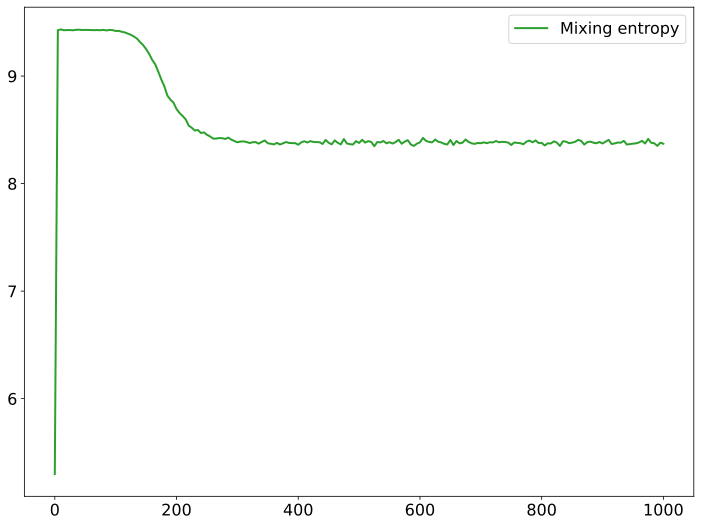

In [27]:
P.plot(res["time"], N.log(res["tot_c"])-res["mix_entro"]/res["tot_c"], linewidth=2, color="tab:green", label="Mixing entropy")

P.legend();
